## Measure the 2-point correlation function using DES deep fields data:

* Download the DES galaxy catalog from the DES Data Lab.
* Create a random catalog of galaxies with the same density as the real catalog.
* Calculate the number of pairs of galaxies within a given angular separation for both the real and random catalogs.
* Divide the number of real pairs by the number of random pairs to obtain the 2-point correlation function.


In [2]:
import astropy.io.fits as fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM

# Get the current user's home directory
home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')


# Assuming you have the path to the FITS file stored in thesis_path
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  # Replace with your actual file name


In [3]:
t= Table.read(fits_file_path)
t  



id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class,z,SM
in

In [4]:
masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  # Replace with your actual file name

t3= Table.read(masked)
t3

id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class
int64,f

In [5]:
t=join(t,t3,keys='id')


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')

In [6]:

# Access the columns directly
redshift = t['z']  # Access the 'z' column for redshift
declination = t['dec']  # Access the 'dec' column for declination
right_ascension = t['ra']  # Access the 'ra' column for right ascension

# Optional: explore or analyze the data
print(redshift.shape)  # Check the shape of the redshift array
print(f"Minimum redshift: {redshift.min()}")
print(f"Maximum redshift: {redshift.max()}")



(415091,)
Minimum redshift: 0.037304999999999984
Maximum redshift: 4.613163999999999


In [7]:
# Select redshift subset 
subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11) #solar masses

# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_subset = t['ra'][subset] #[::100]
dec_subset = t['dec'][subset]#[::100]

catalog=SkyCoord(ra=ra_subset*u.deg, dec=dec_subset*u.deg)

N = len(catalog)


def calculate_separations(cat, N):
    """Calculates the angular separation between all pairs of objects in a catalog.

    Args:
        catalog1: An astropy.coordinates.SkyCoord object containing object coordinates.
        N: The number of bins for the separation histogram.

    Returns:
        A numpy array of size N containing the counts of objects in each separation bin.
    """

    separation = cat.separation(cat[:, np.newaxis])

    return separation


In [8]:
def count_pairs_in_theta_bin(cat,theta_edges):
    """Counts the number of pairs of objects in a catalog that have an angular separation
    within a specified theta bin.

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing object coordinates.
        theta_bins: A tuple defining the angular separation bin.

    Returns:
        The number of pairs within the theta bin.
    """
    separation = cat.separation(cat[:, np.newaxis]) 
    theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)

    #for i in range(0,N):
        #for j in range(i, N):
            #theta = calculate_separations(catalog[i],catalog[j])
            #theta_bins = calculate_separations(theta)
            
            #separation = catalog[i].separation(catalog[j]).to('deg').value
            #theta_bins = calculate_separations(SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg), N=50)

            #theta_bins += 1

    return theta_hist


theta_edges=np.linspace(-2.5,0.25,50) #-2.5 and 0.25 are log of the max and min separation in degrees
dd_counts=count_pairs_in_theta_bin(catalog,theta_edges)  
print(dd_counts)

[   28    12    22    20    24    34    38    34    50    66   102   134
   152   172   236   248   360   420   508   588   748   948  1216  1502
  1848  2268  2958  3692  4342  5772  7554  9648 11864 14196 17522 21088
 26476 31398 37736 44654 53178 62694 72880 83102 88720 87172 73284 54380
 28074]


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_2966/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


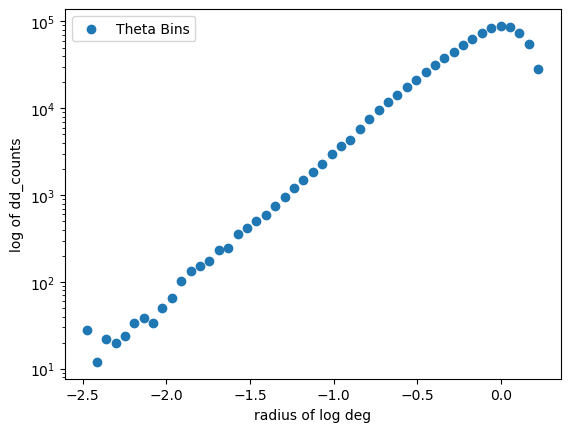

In [9]:
theta_edges=np.linspace(-2.5,0.25,50)

# bin centers
theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

# Plot the theta bins
plt.scatter(theta_cen, dd_counts, label='Theta Bins')
plt.yscale('log')

# Set labels and title
plt.xlabel('radius of log deg')
plt.ylabel('log of dd_counts')
plt.title('')

# Show the plot
plt.legend()
plt.show()

In [10]:
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)
t2

Filename: /Users/otilia/Desktop/Thesis/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


ra,dec,Tilename
float32,float32,bytes9
52.4174,-27.207537,SN-C3_C01
52.449112,-27.199625,SN-C3_C01
52.263237,-27.225185,SN-C3_C01
52.363953,-27.128168,SN-C3_C01
52.19789,-27.176682,SN-C3_C01
52.369183,-27.188385,SN-C3_C01
...,...,...
53.090096,-29.023394,SN-C3_C62
53.002266,-28.988358,SN-C3_C62


In [11]:
# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_2 = t2['ra'][::1000]
dec_2 = t2['dec'][::1000]




In [12]:
random_catalog=SkyCoord(ra=ra_2*u.deg, dec=dec_2*u.deg)



In [13]:
def calculate_2pcf(catalog, random_catalog, theta_edges):
    """Calculates the two-point correlation function (2PCF).

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing data points.
        random_catalog: An astropy.coordinates.SkyCoord object containing random points.
        theta_cen: A numpy array defining the angular separation bin edges.

    Returns:
        A numpy array containing the 2PCF values for each theta bin.
    """

    # Calculate DD counts
    dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

    # Calculate RR counts
    rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
    #Normalise
    norma_dd= dd_counts/np.sum(dd_counts) 
    norma_rr= rr_counts/np.sum(rr_counts) 


    # Calculate 2PCF
    two_pcf = (norma_dd / norma_rr) - 1 # w_measured

    return two_pcf


theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

two_pcf_result = calculate_2pcf(catalog, random_catalog, theta_edges)

print(two_pcf_result)



/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_2966/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


[ 4.34318251  0.69958568  1.49340229  0.68904348  0.72296375  0.76392553
  0.61340236  0.13933167  0.26051065  0.35829466  0.69566085  0.70514529
  0.55436677  0.36786077  0.52115603  0.25946074  0.44441264  0.32211923
  0.26312232  0.150602    0.15319764  0.15114122  0.16626245  0.13383351
  0.10490665  0.076893    0.11240659  0.10685071  0.04051824  0.10491505
  0.1144931   0.1020051   0.09986214  0.07067571  0.08472521  0.06841488
  0.08075606  0.06480137  0.08049011  0.05075073  0.03620803  0.0140921
 -0.00713994 -0.01831074 -0.03503002 -0.0311621  -0.08349272 -0.08065542
 -0.05306455]


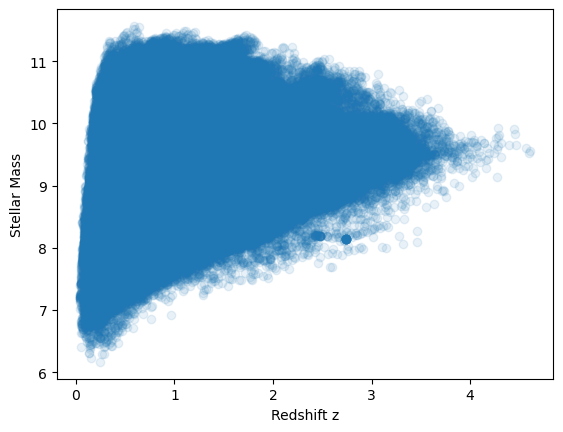

In [14]:
plt.scatter(t['z'],t['SM'],alpha=0.1)
plt.xlabel('Redshift z')
plt.ylabel('Stellar Mass')
plt.show()

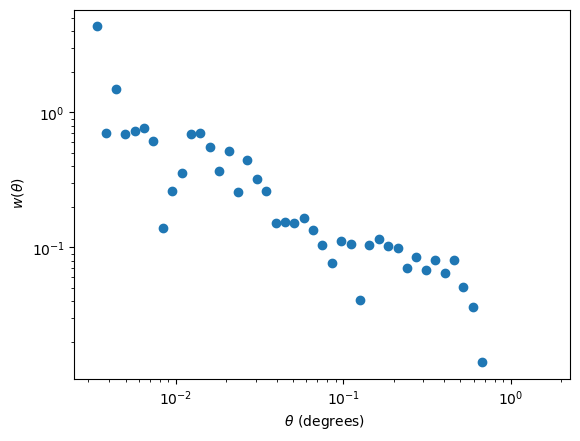

In [15]:
deg_theta_cen=10**theta_cen

plt.scatter(deg_theta_cen, two_pcf_result)
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')

# Show the plot
plt.show()

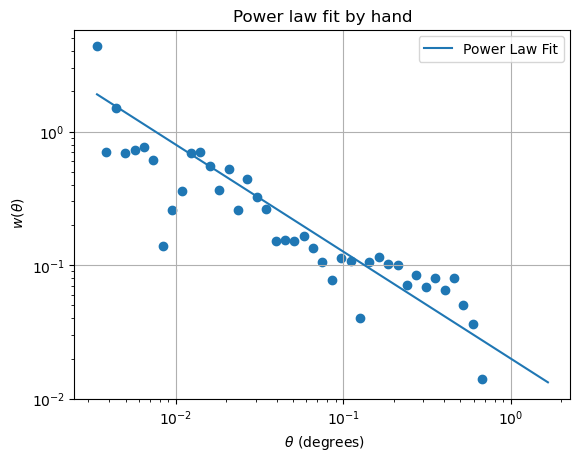

In [16]:
deg_theta_cen=10**theta_cen
A=2*1e-2  #amplitude, best is 2*1e-2 aka 0.02
w_fit= A*deg_theta_cen**(-0.8) #w(theta)

plt.scatter(deg_theta_cen, two_pcf_result)
plt.plot(deg_theta_cen, w_fit, label='Power Law Fit')
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("Power law fit by hand")

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

#### Note: cut first point for better fit

Power-law fit parameters:
  r0: 272.6017931625111
  gamma: -0.6353456881294082


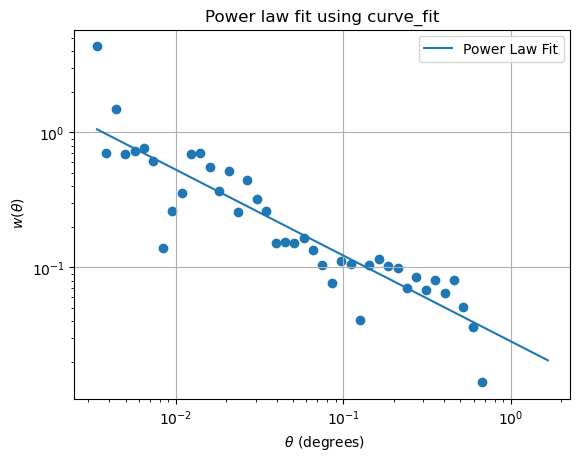

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Peebles & Groth (1975) power law function
def power_law(x, r0, gamma):
    return (x *r0)**gamma

# Fit the power law
popt, pcov = curve_fit(power_law, deg_theta_cen[1:], two_pcf_result[1:], p0=[2*1e-2, -0.8])  # Initial guesses 

# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0])
print("  gamma:", popt[1])

# Create the plot (log scale for y-axis)
plt.scatter(deg_theta_cen, two_pcf_result)
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')

# Set labels and title
# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("Power law fit using curve_fit")
plt.yscale('log')
plt.xscale('log')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

## Integral constraint
#### Due to the relatively small volume probed by the survey, the integral constraint affects w(θ) at large scales.

We adjust the model to take this into account. The correction factor due to the IC can be estimated from the double integration of the true correlation function over the survey area. This integration can be carried out using the random-random pairs from the random catalog following Roche & Eales (1999) where wtrue(θ) is HOD-predicted model. Finally, the model that we fit against the data is simply w(θ) = wtrue(θ) − wIC.


In [18]:
# Calculate DD counts
dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

# Calculate RR counts
rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
#Normalise
norma_dd= dd_counts/np.sum(dd_counts) 
norma_rr= rr_counts/np.sum(rr_counts) 

# Calculate 2PCF aka w(theta)= DD/RR - 1 
two_pcf = (norma_dd / norma_rr) - 1

w_IC = np.sum(w_fit * rr_counts / np.sum(rr_counts)) #IC = w_fit * RR(theta) / SUM(RR)

#ideally we want to use the w_true in the IC but we can't know it so we use w_fit

# w_measured is DD/RR- 1

w= two_pcf + np.sum(w_IC) # w_measured + w_IC 


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_2966/4266226276.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


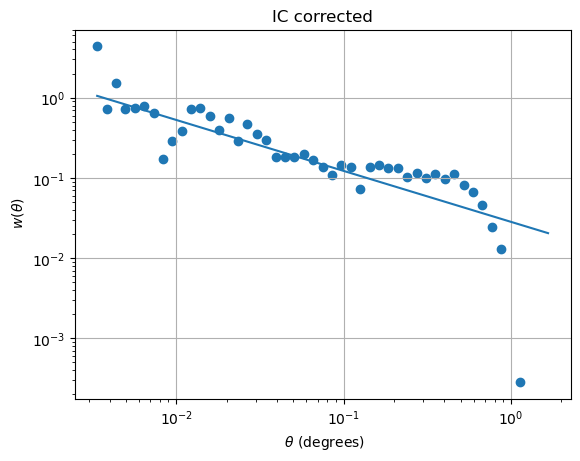

In [19]:
plt.scatter(deg_theta_cen, w)
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("IC corrected")

# Show the plot
plt.grid(True)
plt.show()


## Implementing Gaussian Approximation for Errorbars

The Gaussian approximation to Poisson errors assumes that, for large counts, the Poisson distribution can be approximated by a normal distribution with mean and variance equal to the Poisson parameter 1  (in this case, the number of pairs). This approximation is reasonable when the number of pairs is sufficiently large.

In the Gaussian approximation, the fractional error is 1/sqrt(N pairs). We'll treat the RR part as being noiseless, and all the error as coming from Poisson error on the counting of DD pairs. So the errorbar on the ratio DD/RR is, ( 1 / sqrt(number of  DD pairs) ) * DD/RR

Power-law fit parameters:
  r0: 272.6017931625111
  gamma: -0.6353456881294082


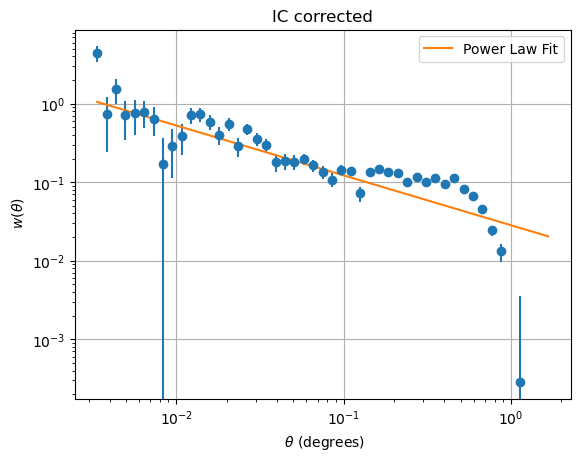

In [20]:

    
fractional_error = 1 / np.sqrt(dd_counts)
errorbars = fractional_error * (norma_dd / norma_rr)  #So the errorbar on the ratio DD/RR is: ( 1 / sqrt(number of  DD pairs) ) * DD/RR

plt.errorbar(deg_theta_cen, w, yerr=errorbars, fmt='o')
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')

plt.yscale('log')
plt.xscale('log')

# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0])
print("  gamma:", popt[1])

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("IC corrected")

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

#### See that despite the fact that the number of DD pairs is very high at large separations, the error on DD/RR - 1 is quite large. At small separations, the fact that there are few DD pairs leads to large errors too.

## PyMC

In [21]:
import pymc as pm
import arviz as az



## Implementing IC in model

In [22]:
w_fit= 2e-2* deg_theta_cen**(-0.8)
cuts=(deg_theta_cen>3e-3) & (deg_theta_cen <1) #define valid values
X= deg_theta_cen[cuts]
Y= w_fit[cuts]
Y_err = errorbars[cuts]
mask_rr= rr_counts[cuts]


# Build the PyMC model
with pm.Model() as model:
    # put our RR pair counts in tensor form    
    rr = pm.ConstantData("rr", mask_rr, dims="observation")

    # Define priors
    power= pm.Normal("power", mu= -0.8, sigma=10)
    A = pm.Normal("A", mu=2e-2, sigma=10)
    
    Y_pred = A * (X** power)
    IC = pm.math.sum(A * (X** power) * rr / pm.math.sum(rr))
    
    total_sigma=np.sqrt(Y_err**2)
    
    # Define likelihood
    likelihood = pm.Normal("Y", mu=Y_pred-IC, sigma=total_sigma, observed=Y, dims="observation")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(3000)

#Extract posterior samples
power_post_parent= np.array(idata.posterior['power']).flatten()
A_post_parent = np.array(idata.posterior['A']).flatten()
    
power_median = np.median(power_post_parent)
A_median = np.median(A_post_parent)

print('power_median',power_median)
print('A_median', A_median)


/Users/otilia/anaconda3/lib/python3.11/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [power, A]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


power_median 0.004351217842708428
A_median -5.950470464079675


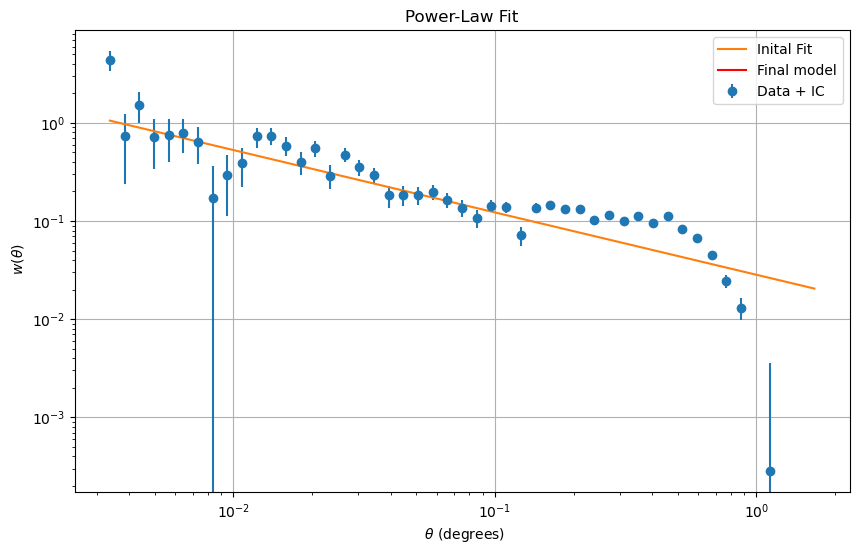

In [23]:

# Plot the data and fitted function
plt.figure(figsize=(10, 6))

plt.errorbar(deg_theta_cen, w, yerr=errorbars, fmt='o',label="Data + IC ") # w is data + IC
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Inital Fit')

plt.plot(X, A_median * X**power_median, label="Final model", color="red")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Power-Law Fit")
plt.grid(True)

plt.show()





In [24]:
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'serif','size':18})
plt.rc('text', usetex=True) # comment out this line if you don't have latex installed




In [25]:
def w_th(A,power,theta,rr):
    IC = np.sum(A * (theta**power) * rr / np.sum(rr))
    return A * (theta**power) - IC

z_mean = 0.65
theta= np.arange(3e-3,10,0.2)


# Choose the index of the point to remove
index_to_remove = 49  # Replace with the desired index

# Create a new array without the removed point
theta_new = np.delete(theta, index_to_remove)

print(theta_new.shape)

(49,)


ValueError: operands could not be broadcast together with shapes (49,) (45,) 

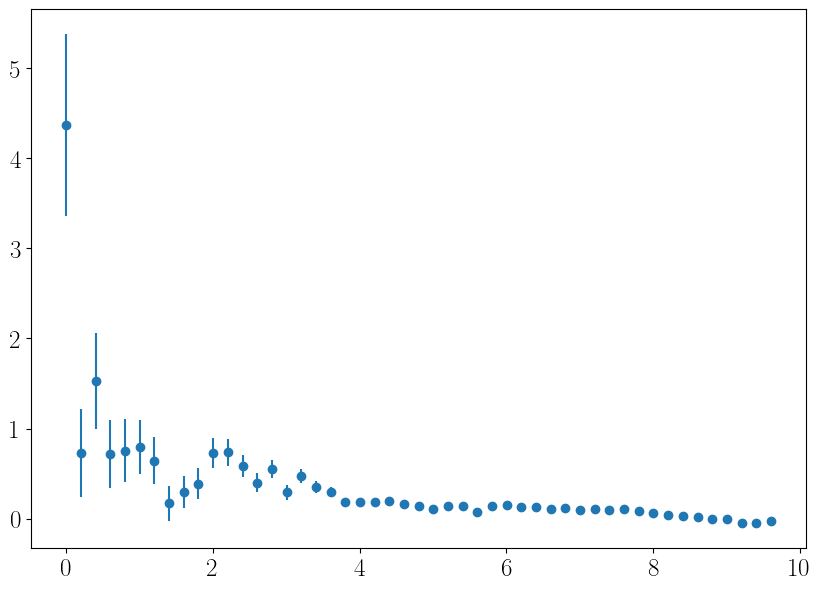

In [26]:

fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(theta_new, w, yerr=errorbars, fmt='o', label='COSMOS')
ax.plot(theta_new, w_th(A_median, power_median, theta_new, mask_rr),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig("clustering.png")
plt.show()

In [ ]:
with pm.Model() as model:
    # Define prior for power-law parameters
    r0 = pm.Normal("r0", mu=popt[0])  # Adjust standard deviation as needed
    gamma = pm.Normal("gamma", mu=popt[1])

    # Define expected value based on power law
    expected_w = pm.Deterministic("expected_w", power_law(deg_theta_cen, r0, gamma))

    # Model data points with Normal distribution considering fractional error
    w_obs = pm.Normal("w_obs", mu=expected_w, sigma= errorbars, observed=w)


    # Inference
    trace = pm.sample(draws=1000, tune=1000)  # Adjust number of samples as needed

# Plot the fit with credible intervals
az.plot_posterior(trace, var_names=["r0", "gamma"])
az.plot_trace(trace, var_names=["r0", "gamma"])


plt.legend()
plt.show()

## Convert units

In [ ]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)  

# Calculate angular diameter distance (d_A)
d_A = cosmo.angular_diameter_distance(z=0.65)  # Average redshift 


# Convert theta from radians to Mpc
theta_Mpc = d_A * deg_theta_cen

# Convert theta_Mpc to h^-1 Mpc
theta_h_inv_Mpc =  theta_Mpc / (cosmo.H0 * u.km / u.s / u.Mpc)


In [ ]:

fit_mpc = theta_h_inv_Mpc ** (-0.8)
plt.yscale('log')
plt.plot(theta_h_inv_Mpc, fit_mpc, label='Power Law Fit')
plt.scatter(theta_h_inv_Mpc, two_pcf_result)

# Set labels and title
plt.xlabel(r'$ \theta(h^{-1} Mpc)$')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.grid(True)
plt.show()

fit power law and slope of -0.8
integral constraint, check in papers